In [ ]:
## Import required modules
import matplotlib.pyplot as plt # for plotting
import matplotlib # for plotting
import numpy as np # for manipulating arrays
import os # for making/deleting directories
import bioformats # for reading image series
import javabridge # for interfacing with java (required for bioformats)
from tifffile import xml2dict # for parsing the metadata from bioformats
import pickle # for saving python objects and other data
from scipy.optimize import curve_fit # for making fits to the PSF
from scipy.ndimage import gaussian_laplace, gaussian_filter # for dot localization (image filtering)
from skimage import measure # for segmenting images
from skimage.morphology import remove_small_objects, closing, disk, dilation # for morphological filtering of images
from skimage.segmentation import clear_border # for filtering images
from skimage.filters import threshold_otsu
import pandas as pd # for creating and manipulating tabulated data
from collections import Iterable
import itertools
from itertools import product
import copy
import scipy
import trackpy # library containing tracking algorithms
import pywt # wavelet transform library
import re # regex 
import warnings


# settings for making nice pdfs
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "DejaVu Sans"
plt.rcParams['font.family'] = "sans-serif"

javabridge.start_vm(class_path=bioformats.JARS) # start java virtual machine



In [55]:
from pathlib import Path

def search_for(start_folder, name_includes=None, name_excludes=None):
    """
    Search directories for files containing or excluding specific strings.
    
    Parameters
    ----------
    start_folder : str
        Parent directory for recursive filename search.
    
    name_includes : list of strings
        List of strings to include in the search data. Search does not do case matching. 

    name_excludes : list of strings
        List of strings to exclude from the search. Search does not do case matching. 
        
    Returns
    -------
    Two lists: 1) list of file names, 2) list of the absolute file path.
    
    """
    filenames_list = []
    filepath_list = []
    for path in Path(start_folder).rglob('*.*'):

        parent_folder = path.parent.name
        if parent_folder in name_excludes:
            continue   

        if (all([name.lower() in path.name.lower() for name in name_includes])==False) or \
            any([name.lower() in path.name.lower() for name in name_excludes])==True:
            continue
            
        filenames_list.append(path.name)
        filepath_list.append(os.path.join(start_folder,path.parent.name))
    return filenames_list, filepath_list


def get_CZI_metadata(filename,filepath=None,verbose=False):
    """
    Obtains the metadata from a CZI image series.
    
    Parameters
    ----------
    filename : str
               Name of the file from which to retrieve the z-stack.
            
    filepath : str, optional
               Path to the file.
           
    verbose : {T,F}, optional
              If true, prints (sizeX,sizeY,sizeZ,sizeT,num_channels) to standard output
            
    Returns
    -------
    (sizeX,sizeY,sizeZ,sizeT,num_channels) : tuple of ints
                Information on the length of the sizes of the `X`, `Y`, `Z` (spatial) and `T` 
                (temporal) dimensions of the image series and the number of channels, `num_channels`.
                In case of failutre to load, returns a 5-tuple of values 0. 

    metadata : dict, or None
               Dictionary containing the full metadata formatted in the Bioformats OME style. 
               If loading is unsuccessful, `None` is returned.
    """
    
    if not filepath is None:
        czi_image = os.path.join(filepath,filename)
    else:
        czi_image = filename

    if not os.path.exists(czi_image):
        return (0,0,0,0,0), None
        
    metadata = xml2dict(bioformats.get_omexml_metadata(czi_image))
    sizeT = metadata['OME']['Image']['Pixels']['SizeT']
    sizeX = metadata['OME']['Image']['Pixels']['SizeX']
    sizeY = metadata['OME']['Image']['Pixels']['SizeY']
    sizeZ = metadata['OME']['Image']['Pixels']['SizeZ']
    num_channels = len(metadata['OME']['Image']['Pixels']['Channel'])
    
    if verbose:
        print(sizeX,sizeY,sizeZ,sizeT,num_channels)
    
    return (sizeX,sizeY,sizeZ,sizeT,num_channels), metadata


def get_CZI_zstack(filename,frame,channel,filepath=None,img_info=None):
    """
    Obtains a single z-stack from a 3D imaging time-series for a specified time and channel.
    
    Parameters
    ----------
    filename : str
               Name of the file from which to retrieve the z-stack.

    frame : int
               The temporal slice of the image series from which to retrieve the z-stack.
            
    channel : int
               The channel from which to retrieve the z-stack.
            
    filepath : str, optional
               Path to the file.

    img_info : tuple of ints, optional 
               5-tuple containing lengths of the `X`, `Y`, `Z` (spatial), `T` (temporal) dimensions
               of the image series, and the number of channels, `num_channels`.
               E.g. (sizeX,sizeY,sizeZ,sizeT,num_channels). See output of get_CZI_metadata(). 
               Pass these pre-computed values for increased speed in batch processing.
                
    Returns
    -------
    zstack : numpy.ndarray, or None
             Z-stack of the image series specified by the desired `frame`; contains 3 spatial 
             dimensions. If loading is unsuccessful, `None` is returned.
    """
    # prepare file name, check that file exists 
    if not (filepath is None):
        czi_image = os.path.join(filepath,filename)
    else:
        czi_image = filename
    if not os.path.exists(czi_image):
        return None
    
    # retrieve image dimensions, and number of channels
    if img_info is None:
        (sizeX,sizeY,sizeZ,sizeT,num_channels), _ = get_CZI_metadata(filename,filepath=filepath)
    else:
        assert len(img_info) == 5
        (sizeX,sizeY,sizeZ,sizeT,num_channels) = img_info
        
    
    # make sure frame and channel are in bounds
    assert frame < sizeT
    assert channel < num_channels
        
    #initialize array and load z-stack
    zstack = np.zeros((sizeZ, sizeY,sizeX))
    with bioformats.ImageReader(czi_image) as reader:
        for z in range(sizeZ):
            zstack[z,:,:] = reader.read(t=frame,z=z,c=channel)

    return zstack

def get_CZI_zstack_timeseries(filename,frames,channel,filepath=None,img_info=None):
    """
    Obtains a time-series of z-stacks for a specified channel from .CZI data.
    
    Parameters
    ----------
    filename : str
               Name of the file from which to retrieve the z-stack.

    frames : range or list of ints
               The temporal slices of the image series from which to retrieve the z-stack.
            
    channel : int
               The channel from which to retrieve the z-stack.
            
    filepath : str, optional
               Path to the file.

    img_info : tuple of ints, optional 
               5-tuple containing lengths of the `X`, `Y`, `Z` (spatial), `T` (temporal) dimensions
               of the image series, and the number of channels, `num_channels`.
               E.g. (sizeX,sizeY,sizeZ,sizeT,num_channels). See output of get_CZI_metadata(). 
               Pass these pre-computed values for increased speed in batch processing.
                
    Returns
    -------
    zstack : numpy.ndarray, or None
             Z-stack of the image time-series; contains 4 spatial dimensions. 
             If loading is unsuccessful, `None` is returned. Dimensions are (Z,Y,X,T).
             
    """
    # prepare file name, check that file exists 
    if not (filepath is None):
        czi_image = os.path.join(filepath,filename)
    else:
        czi_image = filename
    if not os.path.exists(czi_image):
        return None
    
    # retrieve image dimensions, and number of channels
    if img_info is None:
        (sizeX,sizeY,sizeZ,sizeT,num_channels), _ = get_CZI_metadata(filename,filepath=filepath)
    else:
        assert len(img_info) == 5
        (sizeX,sizeY,sizeZ,sizeT,num_channels) = img_info
    
    # make sure frame and channel are in bounds
    for frame in frames:
        assert frame < sizeT
    assert channel < num_channels
        
    #initialize array and load z-stack
    num_slices = len(frames)
    zstack = np.zeros((sizeZ, sizeY,sizeX,num_slices))
    with bioformats.ImageReader(czi_image) as reader:
        for frame in frames:
            for z in range(sizeZ):
                zstack[z,:,:,frame] = reader.read(t=frame,z=z,c=channel)

    return zstack    
    
    

def natural_sort(l):
    # found here: https://stackoverflow.com/questions/4836710/is-there-a-built-in-function-for-string-natural-sort
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)


def wavelet_filter_zstack(zstack,filtered_levels=[0,4],wavelet_type='haar'):
    """
    Perform 3D (or 4D) discrete wavelet transform and coefficient filtering.
    
    Parameters
    ----------
    zstack : ndarray
        Numpy ndarray containing 3 (or 4) dimensions. Dimensions should all be even for best performance!        
    
    filtered_levels : list of ints
        Wavelet coefficient levels to be removed for the image reconstruction.
        
    Returns
    -------
    rec : ndarray 
        Filtered zstack
        
    num_levels : int
        Number of levels that could be accessed
    """

    ## Do Wavelet-decomposition of the image
    levels = filtered_levels 
    coeffs = pywt.wavedecn(zstack,wavelet_type)

    ## Reconstruct image, after filtering different wavelet coefficients 
    for level in levels:
        if level == 0:
            coeffs[0] = np.zeros_like(coeffs[0])
        else:
            try:
                coeffs[level] = {k: np.zeros_like(v) for k, v in coeffs[level].items()} 
            except:
                warnings.warn(f"Wavelet level {level} does not exist. There are only {len(levels)} levels." + \
                              "Check image input size. max_levels = log2(smallest_dimension_of_data/(filter_size-1))")
    rec = pywt.waverecn(coeffs, wavelet_type) 

    ## crop rec to match zstack 
    if (rec.shape != zstack.shape):
        if len(zstack.shape) == 3:
            rec = rec[0:zstack.shape[0],0:zstack.shape[1],0:zstack.shape[2]]
        elif len(zstack.shape) == 4:
            rec = rec[0:zstack.shape[0],0:zstack.shape[1],0:zstack.shape[2],0:zstack.shape[3]]
        elif len(zstack.shape) == 2:
            rec = rec[0:zstack.shape[0],0:zstack.shape[1]]
            
    return rec

def filter_zstack_DoG(zstack,dog_sigma1 = 1.5,dog_sigma2 = 15,absolute_value=True):
    """
    Applies Difference of Gaussian (DoG) filtering on a single z-stack. 

    Parameters
    ----------
    zstack : numpy.ndarray [sizeZ by sizeY by sizeX]
             Z-stack of the image series for a single channel (containing 3 spatial dimentions)
    
    dog_sigma1 : float, optional
                 Standard deviation of the first Gaussian distribution of the DoG filter. 
                 `dog_sigma1` should be close in size to the "dots" being tracked.
             
    dog_sigma2 : float, optional
                 Standard deviation of the second Gaussian distribution of the DoG filter. 
                 `dog_sigma2` should be ~10-times larger than `dog_sigma1`; it helps to smooth 
                 local sources noise and background of the image. 
    
    absolute_value : {T,F}, optional
                     Toggles on/off taking the absolute value of the DoG filter result. 
                     
    Returns
    -------
    filtered_zstack : numpy.ndarray
                      Absolute value of Difference of Gaussian filtered z-stack. 
    """
    filtered_zstack = gaussian_filter(zstack,dog_sigma1)- gaussian_filter(zstack,dog_sigma2)
    
    if absolute_value==True:
        filtered_zstack = np.abs(filtered_zstack)
    
    return filtered_zstack


def filter_zstack_LoG(img,log_sigma=2,num_std_threshold=0):
    """
    Returns the Laplacian of Gaussian (LoG) filtered image and the image of 
    edges detected by the LoG method applied on the image.
    
    Parameters
    ----------
    img : numpy.ndarray
            Image on which to perform the edge detection.
            
    log_sigma : float
            The standard deviation of the gaussian used in 'Laplacian of Gaussian'. It is
            akin to a smoothing parameter.
            
    num_std_threshold : float
            The number of standard deviations used above "zero" to classify a zero-crossing
            event of the 'Laplacian of Gaussian' as being an edge. Only set `num_std_threshold`
            greater than zero; also, only 
    
    Returns
    -------
    log_img
    
    edges_img
    
    """
    log_img = gaussian_laplace(img, log_sigma)
    threshold = np.absolute(log_img).std() * num_std_threshold
    edges_img = np.zeros(img.shape)
    w = edges_img.shape[1]
    h = edges_img.shape[0]
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            region = log_img[y-1:y+2, x-1:x+2]
            val = log_img[y, x]
            max_val = region.max()
            min_val = region.min()
            if (val > 0):
                zerocross = True if min_val < 0 else False
            else:
                zerocross = True if max_val > 0 else False
            if ((max_val - min_val) > threshold) and zerocross:
                edges_img[y, x] = 1
    return log_img, edges_img 

    
def get_image_objects(zstack_to_mask,zstack,min_size_pixels=20,
                      max_size_pixels=10000,
                      percentile_threshold=99.9,
                      do_dilation=True,
                      return_mask=False):
    """
    Creates a binary mask on the zstack, and segments the binary image. 3D objects are identified
    and selected based on their pixel sizes.
    
    Parameters
    ----------
    zstack_to_mask : numpy.ndarray [sizeZ by sizeY by sizeX]
        zstack used to create the binary mask (possibly filtered)
        
    zstack : numpy.ndarray [sizeZ by sizeY by sizeX]
        zstack used to obtain the intensity values of the dot localization (raw data)
        
    min_size_pixels : int
        Minimum size of object to be extracted by the segmentation
        
    max_size_pixels : int
        Maximum size of object to be extracted by the segmentation
    
    percentile_threshold : float (0 to 100)
        Percentile threshold with which to binarize the zstack and create object masks.
        
    do_dilation : {T,F}
        Perform morphological filtering and size selection on image after binary dilation. Default == True.
        
    return_mask : {T,F}
        Returns the mask. By default, the mask is not returned.
        
    Returns
    -------
    A data frame containing the following column headers:    
    x, y, z, mean_intensity, max_intensity, dot_size_pixels
    
    If return_mask == True:
    blobs : np.ndarray
        The thresholded zstack
    blobs_filt : np.ndarray
        The thresholded zstack, after feature size selection
    
    """
    
    ## Apply threshold to binarize image 
    stack_threshold = percentile_threshold
    blobs = zstack_to_mask.copy()
    blobs[blobs < np.percentile(blobs,stack_threshold)] = 0
    blobs[blobs>0] = 1

    
    if do_dilation == True:
        blobs = dilation(blobs)
        
    
    ## Measure blobs/region properties 
    blobs_labels = measure.label(blobs, background=0) 
    blob_metrics = measure.regionprops(blobs_labels, zstack) ## note that we use the unfiltered zstack as input
    
    # print('labels created')
    # get object centroids i.e. (z,y,x) coordinates, volumes and intensities
    centroids = [tuple(np.array(x.weighted_centroid,dtype=float)) for x in blob_metrics]
    vol = [x.area for x in blob_metrics]
    max_intensity = [x.max_intensity for x in blob_metrics]
    mean_intensity = [x.mean_intensity for x in blob_metrics]

    ## Filter localized dots based on size
    good_dots = [vi for vi, v in enumerate(vol) if ((v >= min_size_pixels) and (v <= max_size_pixels))]

    ## Update the list of localized dots
    X = [centroids[i][2] for i in  good_dots]
    Y = [centroids[i][1] for i in  good_dots]
    Z = [centroids[i][0] for i in  good_dots]

    mean_intensity = [mean_intensity[i] for i in  good_dots]
    max_intensity = [max_intensity[i] for i in  good_dots]
    dot_size_pixels = [vol[i] for i in  good_dots]

    
    df = pd.DataFrame({'x':X, 'y':Y,'z':Z,'mean_intensity':mean_intensity,
                  'max_intensity':max_intensity,'dot_size_in_pixels':dot_size_pixels})
    
    if return_mask == False:
        return df
    
#     blobs_filt = np.zeros_like(blobs)
#     for v in good_dots:
#         blobs_filt[blobs_labels==(v+1)] = 1
    
    return df, blobs#, blobs_filt


def get_localizations_iterative(filtered_zstack_timeseries, 
                                zstack_timeseries,
                                frames, 
                                channel,
                                percentile_threshold=99.95,
                                max_dot_size = 10000,
                                min_dot_size = 20, 
                                search_range=(5,15,15),
                                min_track_length = 15,
                                max_iterations=5,
                                min_dot_size_increment=5,
                                percentile_threshold_increment=0.01,
                                current_iteration=0,
                                verbose=True):
    """
    Use trackpy to create trajectories from dot localizations.
    
    Parameters
    ----------
    filtered_zstack_timeseries : numpy.ndarray
        Post-filtering 4-D zstack of the image series data used to make a binary mask.
        
    zstack_timeseries : numpy.ndarray
        Raw 4-D zstack of the image series data.
    
    frames : range or list of int
        Frames to process.
        
    channel : int
        
    percentile_threshold : float 
        Percentile from 0 to 100 by which to threshold the `filtered_zstack_timeseries`.
        
    max_dot_size : int
        Maximum size of the dots in numbers of pixels
        
    min_dot_size : int
        Minimum size of the dots in numbers of pixels
    
    search_range : 3-tuple of ints
        Maximum frame-to-frame displacement (Z,Y,X) of dots
        
    memory : int
        Number of frames a dot may "disappear" and still be called the same trajectory.
        
    min_track_length : int
        Minimum length of trajectories kept
        
    max_iterations : int
        Maximum number of iterations of parameter updates for trajectory creation
        
    min_dot_size_increment : int
        Increment added to `min_dot_size` if trajectory creation fails.
        
    percentile_threshold_increment : float
        Increment added to `percentile_threshold` if trajectory creation fails by `dot_size_increment`.
        
    current_iteration : int
        Keeps track of the number of iterations. 
    
    Returns
    -------
    dict : dictionary of particle localizations
    dict : dictionary of particle trajectories
    """
    
    if verbose == True:
        print(f"Starting iteration: {current_iteration}")
                  
    loc_df = []
    for frame in frames:
        if verbose==True:
            print(f"Getting objects channel: {ch}, frame: {frame}")

        df = get_image_objects(filtered_zstack_timeseries[:,:,:,frame],
                                                 zstack_timeseries[:,:,:,frame],
                                                 percentile_threshold=percentile_threshold,
                                                 min_size_pixels=min_dot_size,
                                                 max_size_pixels=max_dot_size)
        df['frame'] = [frame]*len(df)
        df['channel'] = [channel]*len(df)
        loc_df.append(df)
    loc_df = pd.concat(loc_df,ignore_index=True)

    if verbose==True:
        print(f"Linking trajectories, channel: {ch}")

    linked_df = None
    count = 0
    while linked_df is None:
        try:
            linked_df = create_trajectories(loc_df, 
                        max_dot_size = max_dot_size,
                        min_dot_size = min_dot_size+min_dot_size_increment*count, 
                        search_range=(5,15,15),
                        min_track_length = 15)
        except:
            if verbose==True:
                print(f"Trajectory linking failed. Incrementing the minimum dot size.")

            # increase the threshold on the minimum dot size
            count += 1
            linked_df = None
            
    # if increasing the minimum dot size threshold does not help
    if linked_df is None:

        if verbose==True:
            print(f"Trajectory linking failed. Re-processing image series with higher percentile threshold.")

        # increase the percentile threshold
        percentile_threshold += percentile_threshold_increment
        loc_df, linked_df = get_localizations_iterative(filtered_zstack_timeseries, 
                                        zstack_timeseries,
                                        frames, 
                                        channels,
                                        percentile_threshold=percentile_threshold,
                                        max_dot_size = max_dot_size,
                                        min_dot_size = min_dot_size, 
                                        search_range=[(5,15,15)],
                                        min_track_length = 15,
                                        max_iterations=5,
                                        current_iteration=current_iteration+1)        

        warnings.warn("One iteration failed")
    return loc_df, linked_df

def create_trajectories(loc_df, 
                        max_dot_size = np.inf,
                        min_dot_size = 0, 
                        search_range=(5,15,15),
                        memory=5,
                        min_track_length = 15):
    """
    Use trackpy to create trajectories from dot localizations.
    
    Parameters
    ----------
    loc_df : Pandas DataFrame
        DataFrame of object localizations in 3D and time. 
    
    max_dot_size : int
        Maximum size of the dots in numbers of pixels
        
    min_dot_size : int
        Minimum size of the dots in numbers of pixels
        
    search_range : 3-tuple of ints
        Maximum frame-to-frame displacement (Z,Y,X) of dots
        
    memory : int
        Number of frames a dot may "disappear" and still be called the same trajectory.
        
    min_track_length : int
        Minimum length of trajectories kept
    
    Returns
    -------
    dict : dictionary of particle trajectories
    """
    
    # filter the trajectories based on dot size
    tmp_df = loc_df.copy()
    tmp_df = tmp_df[(tmp_df.dot_size_in_pixels<max_dot_size) & ((tmp_df.dot_size_in_pixels>min_dot_size))]
    
    # create trajectories
    tmp_df = trackpy.link_df(tmp_df, \
            search_range=tuple(search_range), \
            memory=memory)
    
    # filter trajectories based on minimum length
    tmp_df = tmp_df.groupby('particle').filter(lambda x: len(x) > min_track_length)

    return tmp_df

In [320]:
def link_trajectories_across_channels(linked_df, 
                                      min_overlap_length=10,
                                     corrcoeff_min =0.3,
                                     distance_max = 35):
    
    fake_linked_df = linked_df.copy()

    # get 4D tracks for Channel 0
    particles0 = list(set(fake_linked_df[fake_linked_df.channel==0].particle))
    tracks_df0 = {}
    for p in particles0:
        X = fake_linked_df[fake_linked_df.particle==p][['frame','x','y','z']].values
        tracks_df0[p] = X

    # get 4D tracks for Channel 1
    particles1 = list(set(fake_linked_df[fake_linked_df.channel==1].particle))
    tracks_df1 = {}
    for p in particles1:
        X = fake_linked_df[fake_linked_df.particle==p][['frame','x','y','z']].values
        tracks_df1[p] = X

    min_id_value = np.min(particles1)
    
    ## Find likely pairs of trajectories
    likely_pairs = []
    for p0i in tracks_df0:
        p0 = tracks_df0[p0i]
        for p1i in tracks_df1:
            p1 = tracks_df1[p1i]
            times, comm0, comm1 = np.intersect1d(p0[:,0],p1[:,0],return_indices=True)
            if len(times) > min_overlap_length:  
                corrcoeffX = np.corrcoef(p0[comm0,1],p1[comm1,1])[0,1]
                corrcoeffY = np.corrcoef(p0[comm0,2],p1[comm1,2])[0,1]
                corrcoeffZ = np.corrcoef(p0[comm0,3],p1[comm1,3])[0,1]
#                 residualsX = np.mean(np.abs(p0[comm0,1]-p1[comm1,1]))
#                 residualsY = np.mean(np.abs(p0[comm0,2]-p1[comm1,2]))
#                 residualsZ = np.mean(np.abs(p0[comm0,3]-p1[comm1,3]))
                residualsX = (np.abs(p0[comm0,1]-p1[comm1,1]))
                residualsY = (np.abs(p0[comm0,2]-p1[comm1,2]))
                residualsZ = (np.abs(p0[comm0,3]-p1[comm1,3]))
                distance = np.sqrt(residualsX**2+residualsY**2+residualsZ**2)

                # link trajectories if they satisfy a minimum correlation coefficient 
                # and are within an expected maximum distance (in nm) of residuals_max
                corrcoeff_good = all([corrcoeff_min < c for c in [corrcoeffX,corrcoeffY,corrcoeffZ]])
                residuals_good = all(distance < distance_max)
                if corrcoeff_good and residuals_good:
                    likely_pairs.append((int(p0i),int(p1i)))

    ################## REFINE THE PAIRING###################
    # cluster trajectories together 
    # find conflicts or overlaps

    clusters = find_clusters(likely_pairs)        
    likelier_pairs = []
    # generate all possible orderings within the cluster
    # for each ordering:
    #     check for overlaps within a channel 
    #      -- if overlap exists, discard this; continue
    #     check for continuous overlap across channels for all segments
    #       -- if overlap is non-contiguous discard; continue
    #     if overlaps are contiguous in time and non-overlapping within a channel
    #       -- score the total length of contig, score average correlation, score average distance; store
    # for each stored/scored ordering
    for ci, c in enumerate(clusters):
        if len(c) < 2:
            continue
        elif len(c)==2:
            likelier_pairs.append(tuple(sorted(c)))
        else:        
            # generate all possible orderings within the cluster
            orderings = partition_select(c)

            # for each ordering
            good_ordering_metrics = {}
            for si, seq in enumerate(orderings):
                # assert the ordering is at least of size 2
                if len(seq) <= 1:
                    #bad_orderings.append(si)
                    continue

                # split the channels and get time points for each group
                group0 = [tracks_df0[s][:,0] for s in seq if s < min_id_value]
                group1 = [tracks_df1[s][:,0] for s in seq if s >= min_id_value]


                # allow for an overlap equal to the number of groups collected -1
                max_overlap0 = 0#len(group0)-1
                max_overlap1 = 0#len(group1)-1

                # CHECK FOR OVERLAPS WITHIN A CHANNEL
                if len(group0) == 0:
                    continue
                elif len(group0)> 1:
                    has_overlap0 = reduce(np.intersect1d, group0)
                else:
                    has_overlap0 = []
                if len(group1) == 0:
                    continue
                elif len(group1)> 1:
                    has_overlap1 = reduce(np.intersect1d, group1)
                else:
                    has_overlap1 = []
                if (len(has_overlap0)>max_overlap0 or len(has_overlap1)>max_overlap1)==True:
                    #bad_orderings.append(si)
                    continue

                # CHECK FOR FULLY CONNECTED TRAJECTORIES
                # count the number of connections for each trajectory
                num_links = {f"group0_{k}":0 for k in range(len(group0))}
                num_links.update({f"group1_{k}":0 for k in range(len(group1))})
                for gi0, g0 in enumerate(group0):
                    for gi1, g1 in enumerate(group1):
                        intersect = np.intersect1d(g0,g1)
                        if len(intersect)> 0:
                            num_links[f"group0_{gi0}"] += 1
                            num_links[f"group1_{gi1}"] += 1
                # if any elements are disconnected, remove this ordering 
                for key in num_links:
                    if num_links[key] == 0:
                        #bad_orderings.append(si)
                        continue

                # WITH THE REMAINING "GOOD ORDERINGS", compute various metrics
                # combine all group0 together
                # combine all group1 together
                times0 = group_arrays(group0)
                times1 = group_arrays(group1)
                times, comm0, comm1 = np.intersect1d(times0,times1,return_indices=True)


                # get X, Y, Z positions for the trajectory
                groupX0 = group_arrays([tracks_df0[s][:,1] for s in seq if s < min_id_value])
                groupX1 = group_arrays([tracks_df1[s][:,1] for s in seq if s >= min_id_value])
                groupY0 = group_arrays([tracks_df0[s][:,2] for s in seq if s < min_id_value])
                groupY1 = group_arrays([tracks_df1[s][:,2] for s in seq if s >= min_id_value])
                groupZ0 = group_arrays([tracks_df0[s][:,3] for s in seq if s < min_id_value])
                groupZ1 = group_arrays([tracks_df1[s][:,3] for s in seq if s >= min_id_value])

                # get only the overlapping subset of trajectory values
                groupX0 = groupX0[comm0]
                groupX1 = groupX1[comm1]
                groupY0 = groupY0[comm0]
                groupY1 = groupY1[comm1]
                groupZ0 = groupZ0[comm0]
                groupZ1 = groupZ1[comm1]

                # get mean correlation coefficient 
                corrcoeff = np.corrcoef(groupX0,groupX0)[0,1]/3 + \
                            np.corrcoef(groupY0,groupY0)[0,1]/3 + \
                            np.corrcoef(groupZ0,groupZ0)[0,1]/3

                # get the mean distance 
                residuals = np.nanmedian(np.sqrt((groupX0-groupX1)**2 + \
                                            (groupY0-groupY1)**2 + \
                                            (groupZ0-groupZ1)**2))

                #print((ci, si))
                # get the overlap length
                good_ordering_metrics[si] = (len(times),residuals,corrcoeff)

            # sort by longest trajectory first
            best_lengths = sorted(good_ordering_metrics, key=lambda k: good_ordering_metrics[k][0],reverse=True)

#             best_trajectory_idx = np.argmin(best_lengths)
            # sort by hightest correlation first
            best_correlations = sorted(good_ordering_metrics, key=lambda k: good_ordering_metrics[k][2],reverse=True)

            # sort by lowest distance first
            best_distance = sorted(good_ordering_metrics, key=lambda k: good_ordering_metrics[k][1],reverse=False)

            # ranked choice vote
            rank_choice =  {k : 0 for k in best_lengths}
            for rank, bl, bc, bd in zip(range(len(best_lengths)),best_lengths,best_correlations,best_distance):
                rank_choice[bl] += rank
                #rank_choice[bc] += rank  # this metric is useless here -- most correlations are close to 1
                #rank_choice[bd] += rank

            # get best ranked trajectory
            min_rank = min(rank_choice.values()) 
            best_trajectory_idx = [key for key in rank_choice if rank_choice[key] == min_rank] 
            best_trajectory_idx = best_trajectory_idx[0]

            # note, these may not be *pairs*, but a tuples of some length 
            likelier_pairs.append(orderings[best_trajectory_idx]) 

    # update likely_pairs with likelier pairs
    likely_pairs = []
    for lp in likelier_pairs:
        lp = sorted(lp)
        if len(lp)==2:
            likely_pairs.append(tuple(lp))
        else:

            #print(lp)
            for lpi in lp[1:]:
                likely_pairs.append((lp[0],lpi) )
    # update particle names
    for p1i, p2i in likely_pairs:
        fake_linked_df['particle'].replace(p2i,p1i,inplace=True)

    linked_particles_ids = list(set([x[0] for x in likely_pairs]))
    return fake_linked_df, linked_particles_ids
    
        
        

def find_clusters( tuples ):
    # https://stackoverflow.com/questions/21646703/grouping-elements-from-2-tuples-recursively
    clusterlist=[]
    # clustermap maps an element to the id of the containing
    # cluster within clusterlist
    clustermap = {}

    # here we find the current cluster id for elem, by following the
    # chain within clusterlist, and replace that entire chain
    # with the new cluster id n.   We return the old cluster id.
    def set_cluster_id( elem, n ):
        if elem not in clustermap:
            return None
        k = clustermap[elem]
        # clusters may be replaced by references to other clusters,
        # we follow that chain
        while k < n and isinstance( clusterlist[k], int ):
            k1 = clusterlist[k]
            # this is optional, we make the chain shorter
            # by making this entry point directly to the current cluster
            clusterlist[k] = n
            k = k1
        return k

    for t in tuples:
        # for each tuple we create a new cluster
        thiscluster = set(t)
        n = len( clusterlist ) # the id of thiscluster
        for x in t:
            # we absorb existing clusters into the new one
            # if there is overlap
            k = set_cluster_id(x, n)
            if k is not None and k != n:
                thiscluster.update( clusterlist[k] )
                # we replace the existing cluster
                # with a reference to the new one
                clusterlist[k] = n 
            clustermap[x] = n
        clusterlist.append(thiscluster)

    return [ tuple(x) for x in clusterlist if isinstance( x, set ) ]  
  

def partition_select(vals,min_sz=2):
    """
    This function generates a unique list of all possible partitions
    between the items in collection. It also removes all partitions 
    smaller than min_sz in length.
    
    """
    vals = list(vals)
    
    def _partition(collection):
        #https://stackoverflow.com/questions/19368375/set-partitions-in-python
        if len(collection) == 1:
            yield [ collection ]
            return
        first = collection[0]
        for smaller in _partition(collection[1:]):
            # insert `first` in each of the subpartition's subsets
            for n, subset in enumerate(smaller):
                yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
            # put `first` in its own subset 
            #yield [ [ first ] ] + smaller
            yield [[first]] + smaller
         
    ordering = list(_partition(vals))
    flat_list = []
    for sublist in ordering:
        for item in sublist:
            flat_list.append(tuple(item))
    flat_list = list(set(flat_list))
    return [fl for fl in flat_list if len(fl)>= min_sz]

def group_arrays(list_of_arrays):
    return np.array(reduce(lambda x,y: list(x)+list(y),list_of_arrays))


def filter_large_displacements_in_trackpy_trajectories(linked_df,distance_max=35):
    new_df_list = []
    for ch in [0,1]:
        for p in linked_df.particle.unique():
            times = linked_df.query(f"(particle=={p}) and (channel=={ch})").frame.values
            x = linked_df.query(f"(particle=={p}) and (channel=={ch})").x.values
            y = linked_df.query(f"(particle=={p}) and (channel=={ch})").y.values
            z = linked_df.query(f"(particle=={p}) and (channel=={ch})").z.values
            mean_intensity = linked_df.query(f"(particle=={p}) and (channel=={ch})").mean_intensity.values
            max_intensity = linked_df.query(f"(particle=={p}) and (channel=={ch})").max_intensity.values
            dot_size_in_pixels = linked_df.query(f"(particle=={p}) and (channel=={ch})").dot_size_in_pixels.values
            particle = linked_df.query(f"(particle=={p}) and (channel=={ch})").particle.values
            channel = linked_df.query(f"(particle=={p}) and (channel=={ch})").channel.values    

            bad_frames = np.r_[0,np.abs(np.diff(x))< distance_max ] == 1 
            if len(bad_frames) - sum(bad_frames)- 1 > 0:
                # find change points
                changepoints = np.r_[np.where(bad_frames==False)[0],np.inf]

                ind0 = []
                ind1 = []

                ind = 0
                count = 0
                for frame in range(len(x)):
                    if frame < changepoints[count]:
                        if  ind ==0:
                            ind0.append(frame)
                        else:
                            ind1.append(frame)

                    if frame == changepoints[count]:
                        count+=1
                        if  ind ==0:
                            ind1.append(frame)
                            ind = 1
                        else:
                            ind0.append(frame)
                            ind = 0
                ind_keep = np.argmax([len(ind0),len(ind1)])
                if ind_keep == 0:
                    x = [x[pos] for pos in ind0]
                    y = [y[pos] for pos in ind0]
                    z = [z[pos] for pos in ind0]
                    mean_intensity = [mean_intensity[pos] for pos in ind0] 
                    max_intensity = [max_intensity[pos] for pos in ind0]
                    dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind0]
                    particle = [particle[pos] for pos in ind0]
                    channel = [channel[pos] for pos in ind0]
                    times = [times[pos] for pos in ind0]
                else:
                    x = [x[pos] for pos in ind1]
                    y = [y[pos] for pos in ind1]
                    z = [z[pos] for pos in ind1]
                    mean_intensity = [mean_intensity[pos] for pos in ind1]
                    max_intensity = [max_intensity[pos] for pos in ind1]
                    dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind1]
                    particle = [particle[pos] for pos in ind1]
                    channel = [channel[pos] for pos in ind1]
                    times = [times[pos] for pos in ind1]

            ## filter out big displacements in Y
            bad_frames = np.r_[0,np.abs(np.diff(y))< distance_max ] == 1 
            if len(bad_frames) - sum(bad_frames)- 1 > 0:
                # find change points
                changepoints = np.r_[np.where(bad_frames==False)[0],np.inf]

                ind0 = []
                ind1 = []

                ind = 0
                count = 0
                for frame in range(len(x)):
                    if frame < changepoints[count]:
                        if  ind ==0:
                            ind0.append(frame)
                        else:
                            ind1.append(frame)

                    if frame == changepoints[count]:
                        count+=1
                        if  ind ==0:
                            ind1.append(frame)
                            ind = 1
                        else:
                            ind0.append(frame)
                            ind = 0
                ind_keep = np.argmax([len(ind0),len(ind1)])
                if ind_keep == 0:
                    x = [x[pos] for pos in ind0]
                    y = [y[pos] for pos in ind0]
                    z = [z[pos] for pos in ind0]
                    mean_intensity = [mean_intensity[pos] for pos in ind0] 
                    max_intensity = [max_intensity[pos] for pos in ind0]
                    dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind0]
                    particle = [particle[pos] for pos in ind0]
                    channel = [channel[pos] for pos in ind0]
                    times = [times[pos] for pos in ind0]
                else:
                    x = [x[pos] for pos in ind1]
                    y = [y[pos] for pos in ind1]
                    z = [z[pos] for pos in ind1]
                    mean_intensity = [mean_intensity[pos] for pos in ind1]
                    max_intensity = [max_intensity[pos] for pos in ind1]
                    dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind1]
                    particle = [particle[pos] for pos in ind1]
                    channel = [channel[pos] for pos in ind1]
                    times = [times[pos] for pos in ind1]

            new_df = pd.DataFrame({'particle':particle,
                          'channel':channel,
                          'frame':times,
                          'x':x,
                          'y':y,
                          'z':z,
                          'mean_intensity':mean_intensity,
                          'max_intensity':max_intensity,
                          'dot_size_in_pixels':dot_size_in_pixels})

            new_df_list.append(new_df)
        
    return pd.concat(new_df_list)

In [ ]:
def filter_large_distance_jumps_in_linked_trajectories(joined_df,distance_max=35,min_length=50):

    for p in joined_df.particle.unique():
        x0 = joined_df[joined_df.particle==p].query('channel==0').x.values
        y0 = joined_df[joined_df.particle==p].query('channel==0').y.values
        z0 = joined_df[joined_df.particle==p].query('channel==0').z.values
        t0 = joined_df[joined_df.particle==p].query('channel==0').frame.values
        
        x1 = joined_df[joined_df.particle==p].query('channel==1').x.values
        y1 = joined_df[joined_df.particle==p].query('channel==1').y.values
        z1 = joined_df[joined_df.particle==p].query('channel==1').z.values
        t1 = joined_df[joined_df.particle==p].query('channel==1').frame.values
        
        if len(x0)<=min_length:
            continue
        if len(x1)<=min_length:
            continue
        if len(t0)==0 or len(t1)==0:
            continue

        # get data frame stuff
        times = linked_df.query(f"(particle=={p}) and (channel=={ch})").frame.values
        x = linked_df.query(f"(particle=={p}) and (channel=={ch})").x.values
        y = linked_df.query(f"(particle=={p}) and (channel=={ch})").y.values
        z = linked_df.query(f"(particle=={p}) and (channel=={ch})").z.values
        mean_intensity = linked_df.query(f"(particle=={p}) and (channel=={ch})").mean_intensity.values
        max_intensity = linked_df.query(f"(particle=={p}) and (channel=={ch})").max_intensity.values
        dot_size_in_pixels = linked_df.query(f"(particle=={p}) and (channel=={ch})").dot_size_in_pixels.values
        particle = linked_df.query(f"(particle=={p}) and (channel=={ch})").particle.values
        channel = linked_df.query(f"(particle=={p}) and (channel=={ch})").channel.values    

            
            
        # find the consensus data points            
        tq, comm0, comm1 = np.intersect1d(t0,t1,return_indices=True)
        ss = np.argsort(tq)
        tq = tq[ss]
        comm0 = comm0[ss]
        comm1 = comm1[ss]
        x0q = x0[comm0]
        x1q = x1[comm1]
        y0q = y0[comm0]
        y1q = y1[comm1]
        z0q = z0[comm0]
        z1q = z1[comm1]            

        # obtain displacements 
        dx = (x1q-x0q)
        dy = (y1q-y0q)
        dz = (z1q-z0q)

    #     # chromatic shift correction (in nm)
    #     dx = dx - chromatic_aberration_correction(x0q,'./chromatic_shift_X.npy')
    #     dy = dy - chromatic_aberration_correction(y0q,'./chromatic_shift_Y.npy')
    #     dz = dz - chromatic_aberration_correction(z0q,'./chromatic_shift_Z.npy')

        dist = np.sqrt((dx)**2+(dy)**2+(dz)**2)

        bad_frames = np.r_[0,np.abs(np.diff(dist))< distance_max ] == 1 
        if len(bad_frames) - sum(bad_frames)- 1 > 0:
            # find change points
            changepoints = np.r_[np.where(bad_frames==False)[0],np.inf]
            ind0 = []
            ind1 = []
            ind = 0
            count = 0
            for frame in range(len(x)):
                if frame < changepoints[count]:
                    if  ind ==0:
                        ind0.append(frame)
                    else:
                        ind1.append(frame)

                if frame == changepoints[count]:
                    count+=1
                    if  ind ==0:
                        ind1.append(frame)
                        ind = 1
                    else:
                        ind0.append(frame)
                        ind = 0
            ind_keep = np.argmax([len(ind0),len(ind1)])
            if ind_keep == 0:
                x = [x[pos] for pos in ind0]
                y = [y[pos] for pos in ind0]
                z = [z[pos] for pos in ind0]
                mean_intensity = [mean_intensity[pos] for pos in ind0] 
                max_intensity = [max_intensity[pos] for pos in ind0]
                dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind0]
                particle = [particle[pos] for pos in ind0]
                channel = [channel[pos] for pos in ind0]
                times = [times[pos] for pos in ind0]
            else:
                x = [x[pos] for pos in ind1]
                y = [y[pos] for pos in ind1]
                z = [z[pos] for pos in ind1]
                mean_intensity = [mean_intensity[pos] for pos in ind1]
                max_intensity = [max_intensity[pos] for pos in ind1]
                dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind1]
                particle = [particle[pos] for pos in ind1]
                channel = [channel[pos] for pos in ind1]
                times = [times[pos] for pos in ind1]

                ## filter out big displacements in Y
                bad_frames = np.r_[0,np.abs(np.diff(y))< distance_max ] == 1 
                if len(bad_frames) - sum(bad_frames)- 1 > 0:
                    # find change points
                    changepoints = np.r_[np.where(bad_frames==False)[0],np.inf]

                    ind0 = []
                    ind1 = []

                    ind = 0
                    count = 0
                    for frame in range(len(x)):
                        if frame < changepoints[count]:
                            if  ind ==0:
                                ind0.append(frame)
                            else:
                                ind1.append(frame)

                        if frame == changepoints[count]:
                            count+=1
                            if  ind ==0:
                                ind1.append(frame)
                                ind = 1
                            else:
                                ind0.append(frame)
                                ind = 0
                    ind_keep = np.argmax([len(ind0),len(ind1)])
                    if ind_keep == 0:
                        x = [x[pos] for pos in ind0]
                        y = [y[pos] for pos in ind0]
                        z = [z[pos] for pos in ind0]
                        mean_intensity = [mean_intensity[pos] for pos in ind0] 
                        max_intensity = [max_intensity[pos] for pos in ind0]
                        dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind0]
                        particle = [particle[pos] for pos in ind0]
                        channel = [channel[pos] for pos in ind0]
                        times = [times[pos] for pos in ind0]
                    else:
                        x = [x[pos] for pos in ind1]
                        y = [y[pos] for pos in ind1]
                        z = [z[pos] for pos in ind1]
                        mean_intensity = [mean_intensity[pos] for pos in ind1]
                        max_intensity = [max_intensity[pos] for pos in ind1]
                        dot_size_in_pixels = [dot_size_in_pixels[pos] for pos in ind1]
                        particle = [particle[pos] for pos in ind1]
                        channel = [channel[pos] for pos in ind1]
                        times = [times[pos] for pos in ind1]

                new_df = pd.DataFrame({'particle':particle,
                              'channel':channel,
                              'frame':times,
                              'x':x,
                              'y':y,
                              'z':z,
                              'mean_intensity':mean_intensity,
                              'max_intensity':max_intensity,
                              'dot_size_in_pixels':dot_size_in_pixels})

                new_df_list.append(new_df)

    return pd.concat(new_df_list)

In [155]:
linked_df = pd.concat([linked_df_dict[0],linked_df_dict[1]])
joined_df, ids = link_trajectories_across_channels(linked_df)

## Localization pipeline

In [7]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

from functools import reduce
trackpy.quiet()

In [8]:
img_folder = '/mnt/md0/Hansen Lab Dropbox/DataStorage/Imaging/Fbn2/processed/'
name_includes = ['.czi','fbn2','']
name_excludes = ['beads']
filenames_list, filepath_list = search_for(img_folder,name_includes,name_excludes)

In [50]:
# collect localizations in images by chunks
frames = range(365)
f = 0
loc_df_dict = {0:[],1:[]}
linked_df_dict = {0:[],1:[]}
Z_dict = {0:[],1:[]} # just for fast access
for ch in [1]:
    print("Getting czi z-stack")
    
    Z = get_CZI_zstack_timeseries(filenames_list[f],frames,ch,filepath=filepath_list[f])
    Z_dict[ch] = Z
    
    print("Doing wavelet decomposition and reconstruction")
    W4 = wavelet_filter_zstack(Z,filtered_levels=[0,4])
    
    # collect localizations into a big dataframe
    loc_df, linked_df = get_localizations_iterative(W4, Z, frames, ch)
    loc_df_dict[ch] = loc_df
    linked_df_dict[ch] = linked_df
    
# renumber the particle trajectory numbers
particle_count_ch0 = len(linked_df_dict[0].particle.unique())
for pi, p in enumerate(sorted(linked_df_dict[0].particle.unique())):
    linked_df_dict[0]['particle'].replace(p,pi,inplace=True)
for pi, p in enumerate(sorted(linked_df_dict[1].particle.unique())):
    linked_df_dict[1]['particle'].replace(p,pi+particle_count_ch0,inplace=True)

# quality check the trajectories (ensure there are no ridiculous jumps)
linked_df = pd.concat([linked_df_dict[0],linked_df_dict[1]])
linked_df = filter_large_displacements_in_trackpy_trajectories(linked_df,distance_max=35)

# remove linked trajectories with backwards temporal excursions
linked_df = filter_backwards_temporal_excursions(linked_df,distance_max=35)

# link trajectories across channels
joined_df, good_ids = link_trajectories_across_channels(linked_df)

# save intermediate files

# perform "gap filling" - estimate the missing "in between" dot positions

# "fill in" missing data points in space and time and refine the localizations
    
# perform trajectory extension


Getting czi z-stack
Doing wavelet decomposition and reconstruction
Starting iteration: 0
Getting objects channel: 1, frame: 0
Getting objects channel: 1, frame: 1


/home/hbrandao/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:349: RuntimeWarning: invalid value encountered in true_divide
  M[(0,) * self._ndim])


Getting objects channel: 1, frame: 2
Getting objects channel: 1, frame: 3
Getting objects channel: 1, frame: 4
Getting objects channel: 1, frame: 5
Getting objects channel: 1, frame: 6
Getting objects channel: 1, frame: 7
Getting objects channel: 1, frame: 8
Getting objects channel: 1, frame: 9
Getting objects channel: 1, frame: 10
Getting objects channel: 1, frame: 11
Getting objects channel: 1, frame: 12
Getting objects channel: 1, frame: 13
Getting objects channel: 1, frame: 14
Getting objects channel: 1, frame: 15
Getting objects channel: 1, frame: 16
Getting objects channel: 1, frame: 17
Getting objects channel: 1, frame: 18
Getting objects channel: 1, frame: 19
Getting objects channel: 1, frame: 20
Getting objects channel: 1, frame: 21
Getting objects channel: 1, frame: 22
Getting objects channel: 1, frame: 23
Getting objects channel: 1, frame: 24
Getting objects channel: 1, frame: 25
Getting objects channel: 1, frame: 26
Getting objects channel: 1, frame: 27
Getting objects chan

Getting objects channel: 1, frame: 215
Getting objects channel: 1, frame: 216
Getting objects channel: 1, frame: 217
Getting objects channel: 1, frame: 218
Getting objects channel: 1, frame: 219
Getting objects channel: 1, frame: 220
Getting objects channel: 1, frame: 221
Getting objects channel: 1, frame: 222
Getting objects channel: 1, frame: 223
Getting objects channel: 1, frame: 224
Getting objects channel: 1, frame: 225
Getting objects channel: 1, frame: 226
Getting objects channel: 1, frame: 227
Getting objects channel: 1, frame: 228
Getting objects channel: 1, frame: 229
Getting objects channel: 1, frame: 230
Getting objects channel: 1, frame: 231
Getting objects channel: 1, frame: 232
Getting objects channel: 1, frame: 233
Getting objects channel: 1, frame: 234
Getting objects channel: 1, frame: 235
Getting objects channel: 1, frame: 236
Getting objects channel: 1, frame: 237
Getting objects channel: 1, frame: 238
Getting objects channel: 1, frame: 239
Getting objects channel: 

In [321]:
linked_df = pd.concat([linked_df_dict[0],linked_df_dict[1]])
linked_df = filter_large_displacements_in_trackpy_trajectories(linked_df,distance_max=10)
joined_df, good_ids = link_trajectories_across_channels(linked_df)

/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/hbrandao/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

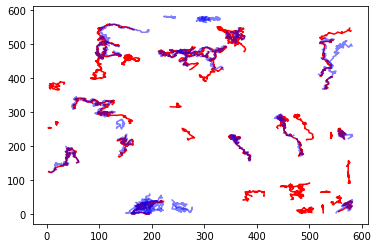

In [322]:
for p in linked_df.particle.unique():
    x = linked_df.query(f"(particle=={p}) and (channel==0)").x.values
    y = linked_df.query(f"(particle=={p}) and (channel==0)").y.values
    if len(x) > 30:
        plt.plot(x,y,'r')
    
    xx = linked_df.query(f"(particle=={p}) and (channel==1)").x.values
    yy = linked_df.query(f"(particle=={p}) and (channel==1)").y.values
    if len(xx) > 30:
        plt.plot(xx,yy,'b',alpha=0.5)


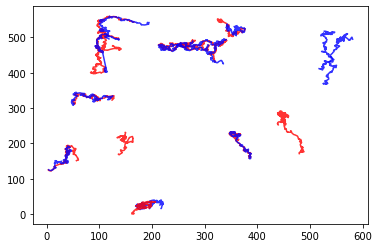

In [323]:
for p in good_ids:
    x = joined_df.query(f"(particle=={p}) and (channel==0)").x.values
    y = joined_df.query(f"(particle=={p}) and (channel==0)").y.values
    if len(x) > 100:
        plt.plot(x,y,'r',alpha=0.8)
    
    xx = joined_df.query(f"(particle=={p}) and (channel==1)").x.values
    yy = joined_df.query(f"(particle=={p}) and (channel==1)").y.values
    if len(xx) > 100:
        plt.plot(xx,yy,'b',alpha=0.8)


/home/hbrandao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/hbrandao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/hbrandao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

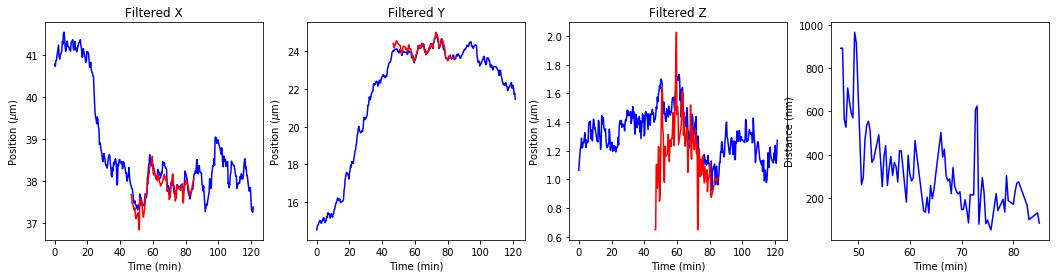

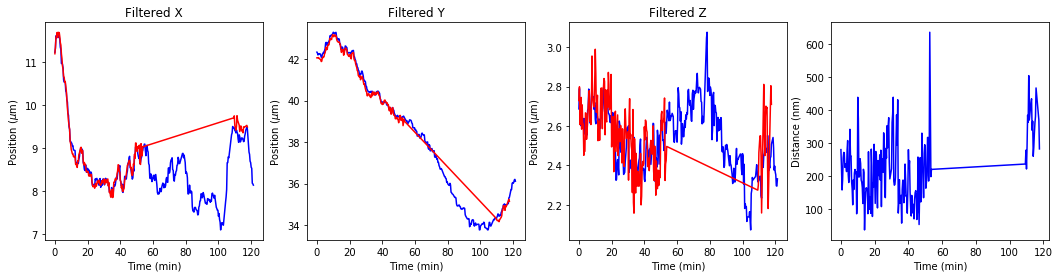

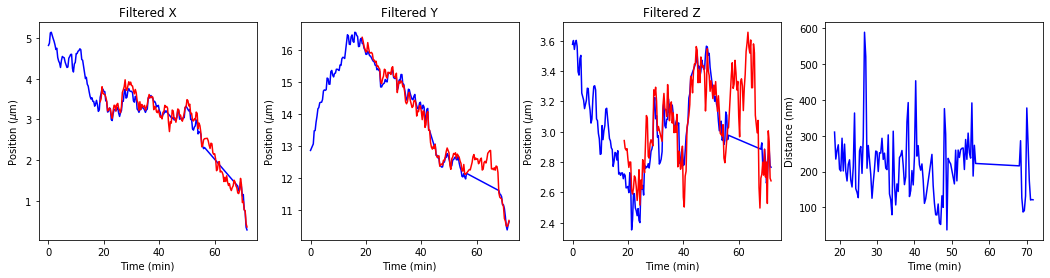

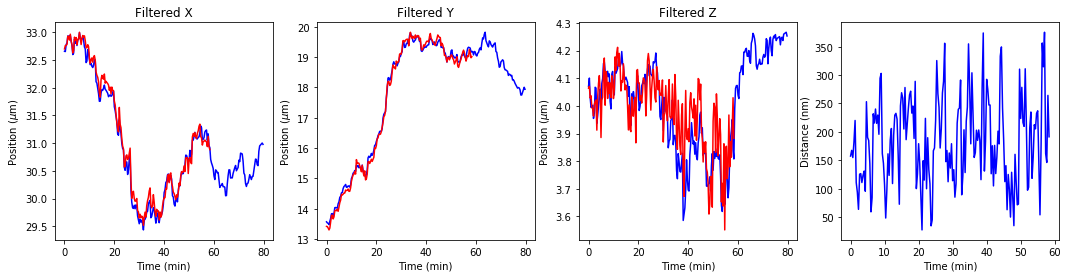

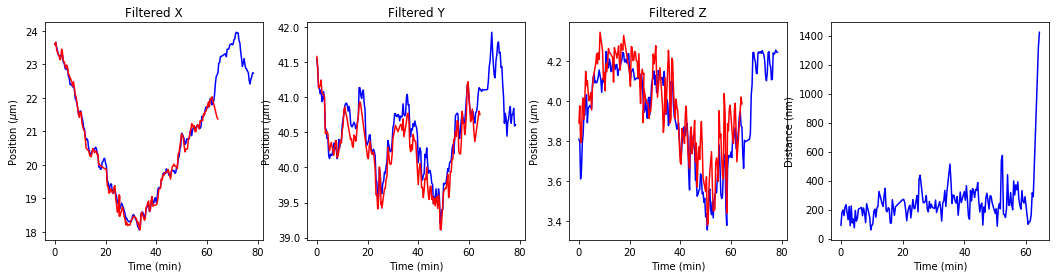

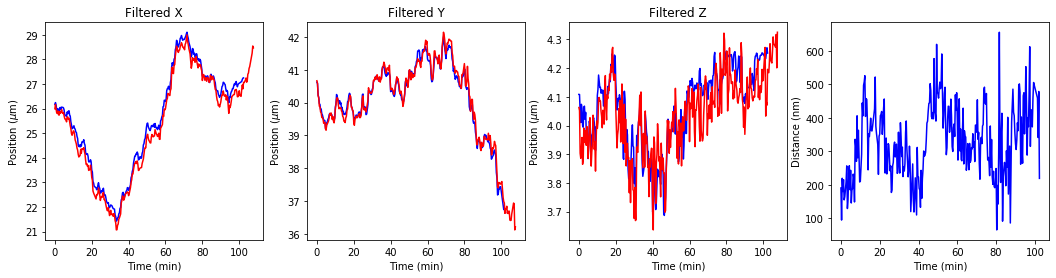

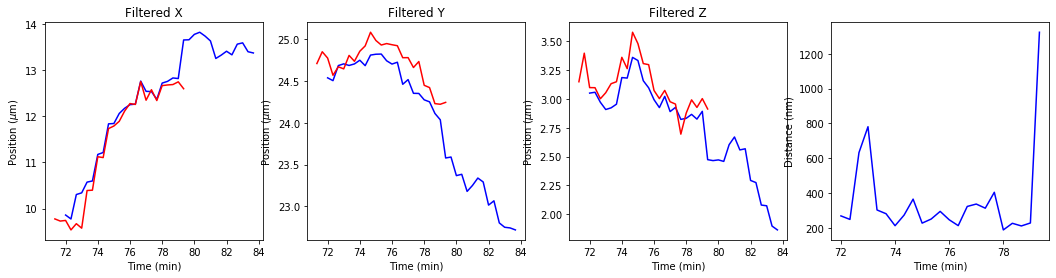

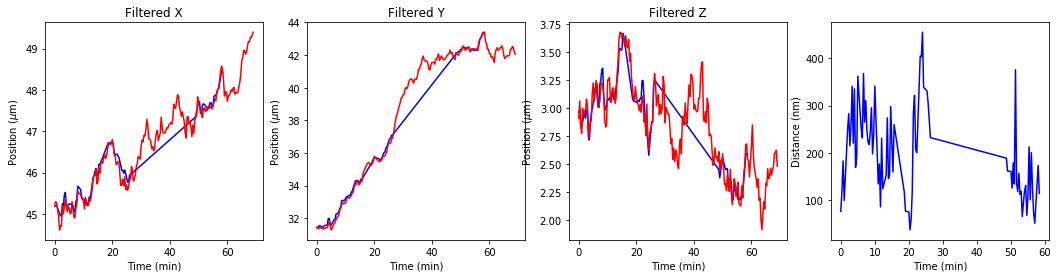

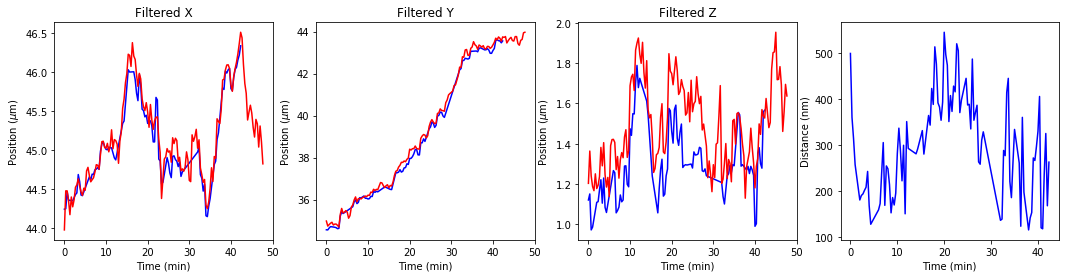

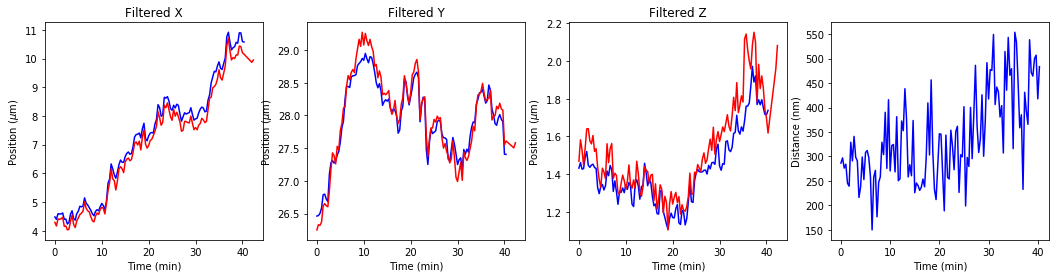

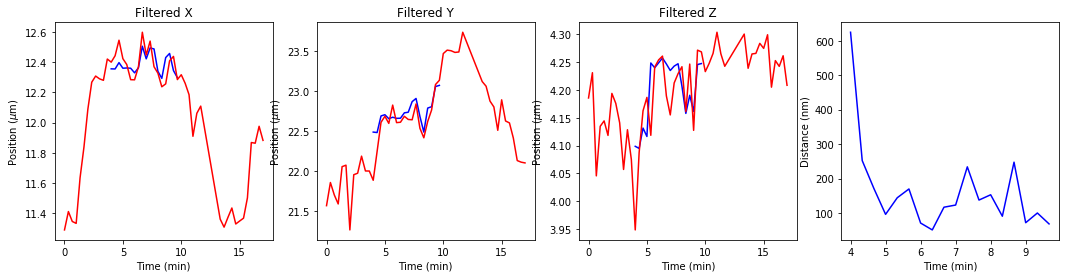

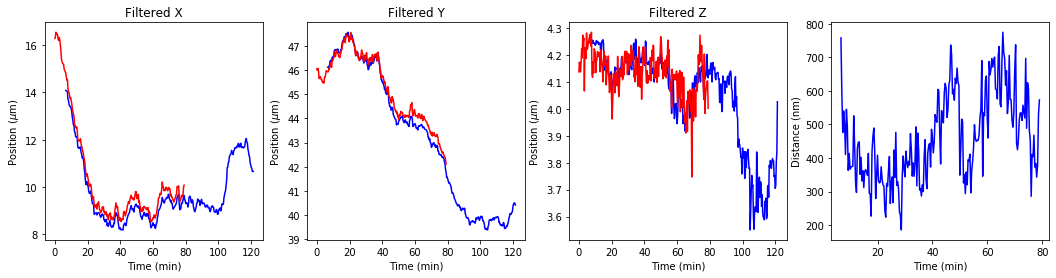

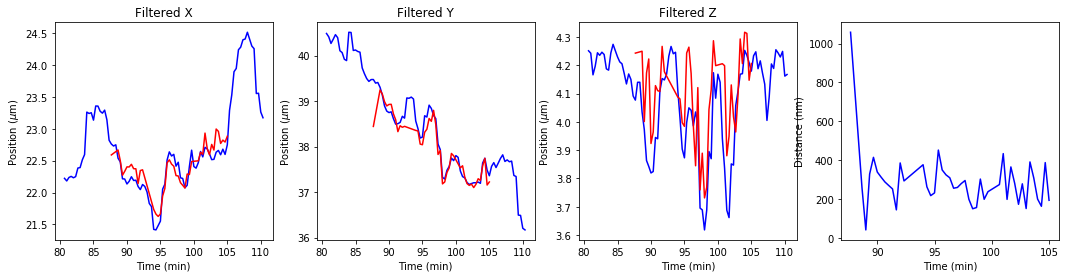

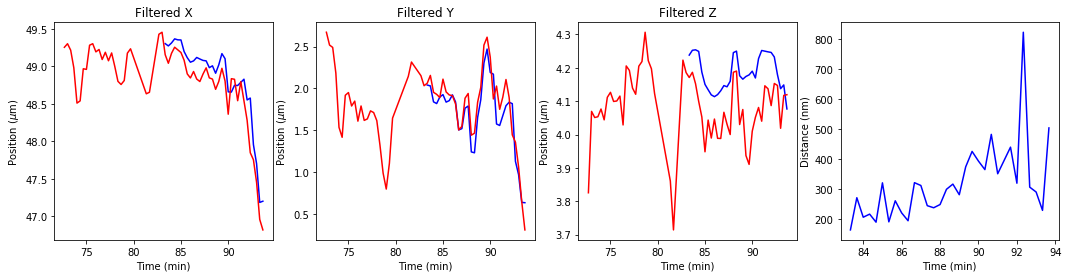

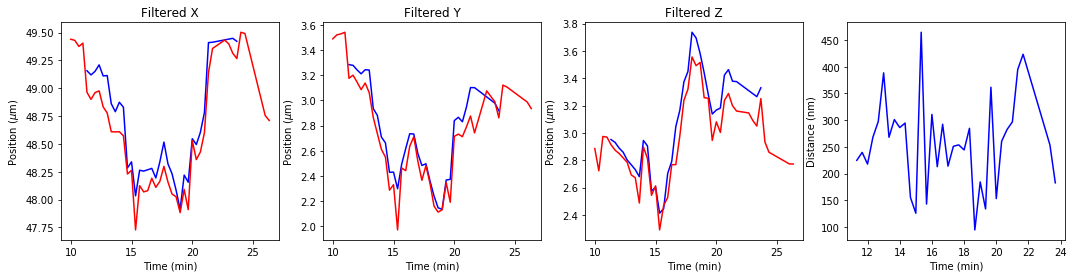

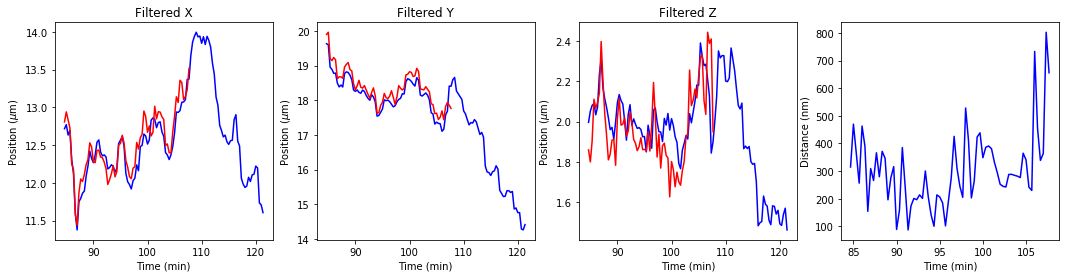

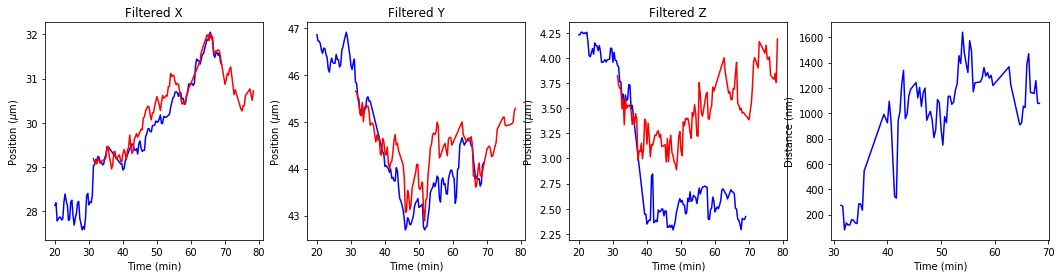

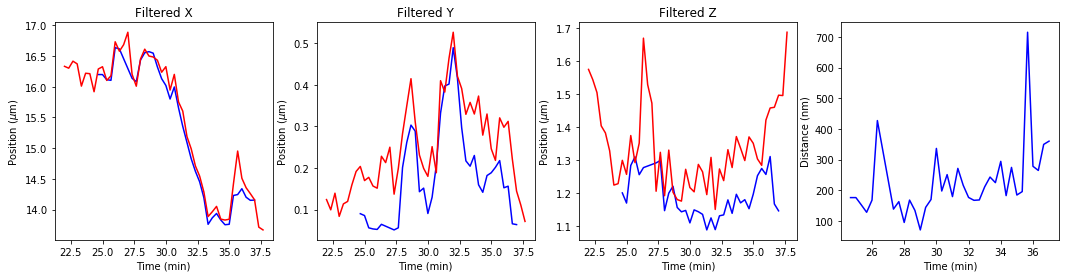

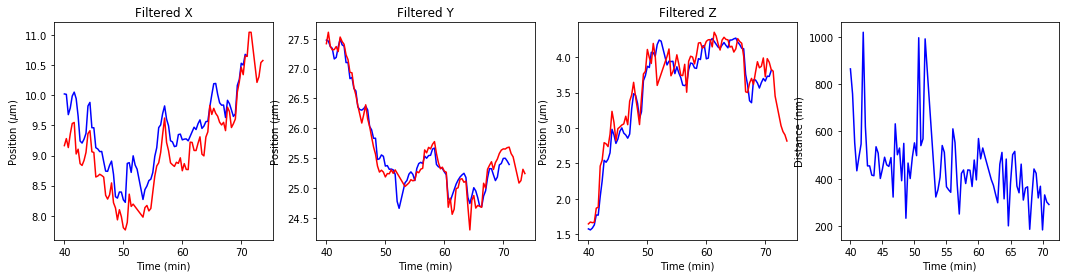

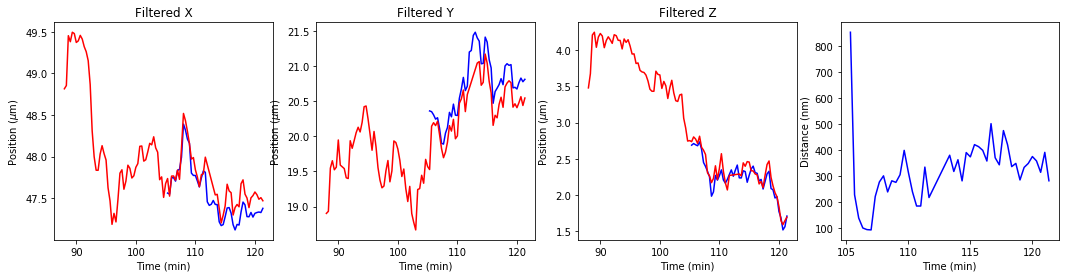

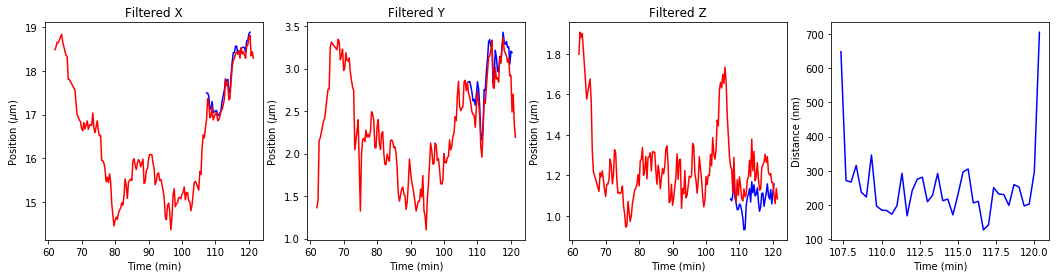

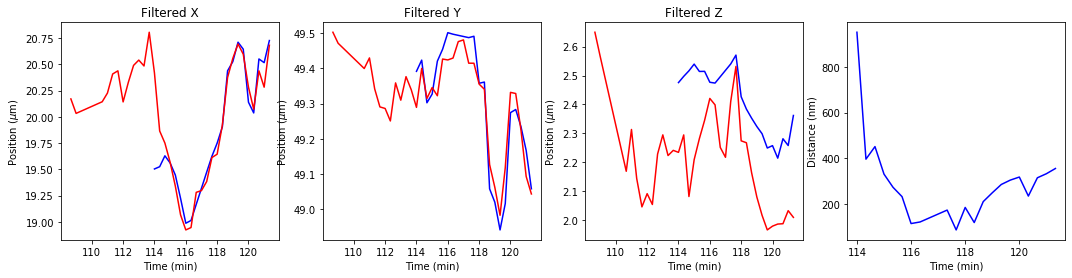

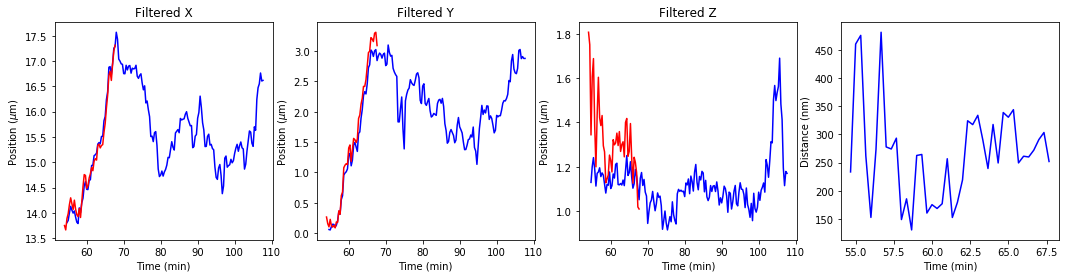

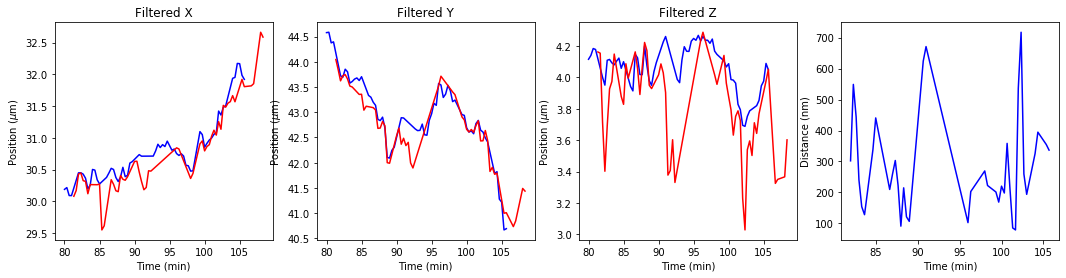

In [324]:
## Plot linked trajectory distances
fx = 85/1000
fy = 85/1000
fz = 150/1000 # um
ft = 20 # sec


for p in good_ids:
    x0 = joined_df[joined_df.particle==p].query('channel==0').x.values
    y0 = joined_df[joined_df.particle==p].query('channel==0').y.values
    z0 = joined_df[joined_df.particle==p].query('channel==0').z.values

    t0 = joined_df[joined_df.particle==p].query('channel==0').frame.values
    x1 = joined_df[joined_df.particle==p].query('channel==1').x.values
    y1 = joined_df[joined_df.particle==p].query('channel==1').y.values
    z1 = joined_df[joined_df.particle==p].query('channel==1').z.values
    t1 = joined_df[joined_df.particle==p].query('channel==1').frame.values

    if len(x0)==0:
        continue
    if len(x1)==0:
        continue
    if len(t0)==0 or len(t1)==0:
        continue

    # find the consensus data points            
    tq, comm0, comm1 = np.intersect1d(t0,t1,return_indices=True)
    ss = np.argsort(tq)
    tq = tq[ss]
    comm0 = comm0[ss]
    comm1 = comm1[ss]
    x0q = x0[comm0]
    x1q = x1[comm1]
    y0q = y0[comm0]
    y1q = y1[comm1]
    z0q = z0[comm0]
    z1q = z1[comm1]            

    # obtain displacements (convert to nm)
    dx = (x1q-x0q)*fx*1000
    dy = (y1q-y0q)*fy*1000
    dz = (z1q-z0q)*fz*1000

#     # chromatic shift correction (in nm)
#     dx = dx - chromatic_aberration_correction(x0q,'./chromatic_shift_X.npy')
#     dy = dy - chromatic_aberration_correction(y0q,'./chromatic_shift_Y.npy')
#     dz = dz - chromatic_aberration_correction(z0q,'./chromatic_shift_Z.npy')

    dist = np.sqrt((dx)**2+(dy)**2+(dz)**2)
#     if any(dist>max_dot_distance):
#         continue
#     dist_array.append(dist)

    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1)
    plt.plot(t0*ft/60,x0*fx,'b')
    plt.plot(t1*ft/60,x1*fx,'r')
    plt.ylabel('Position ($\mu$m)')
    plt.xlabel('Time (min)')
    plt.title('Filtered X')
    plt.subplot(1,4,2)
    plt.plot(t0*ft/60,y0*fy,'b')
    plt.plot(t1*ft/60,y1*fy,'r')
    plt.ylabel('Position ($\mu$m)')
    plt.xlabel('Time (min)')
    plt.title('Filtered Y')
    plt.subplot(1,4,3)
    plt.plot(t0*ft/60,z0*fz,'b')
    plt.plot(t1*ft/60,z1*fz,'r')
    plt.ylabel('Position ($\mu$m)')
    plt.xlabel('Time (min)')
    plt.title('Filtered Z')

    plt.subplot(1,4,4)
    plt.plot(tq*ft/60,dist,'b')
    plt.ylabel('Distance (nm)')
    plt.xlabel('Time (min)')

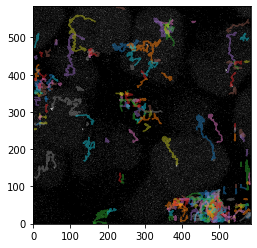

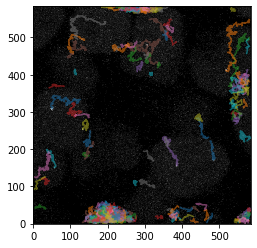

In [54]:
for ch in [0,1]:
    linked_df = linked_df_dict[ch]

    plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
    for p in linked_df.particle.unique():
        y = linked_df.query(f"particle=={p}").y
        x = linked_df.query(f"particle=={p}").x
        i = linked_df.query(f"particle=={p}").max_intensity
#         if np.mean(i) > 0.06:
        plt.plot(x,y,alpha=0.5)
            #print(len(x))
    plt.show()

In [43]:
# linked_df.query(f"particle=={0}").max_intensity

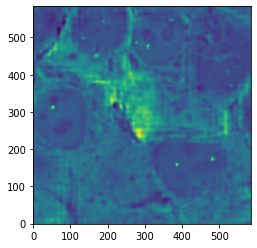

In [28]:
plt.imshow(np.max(W4_gauss[:,:,:,0],axis=0),origin='top')

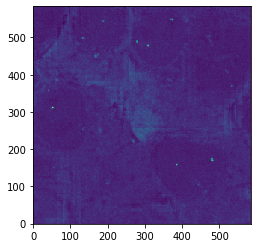

In [33]:
plt.imshow(np.max((W4[:,:,:,0]),axis=0),origin='top')

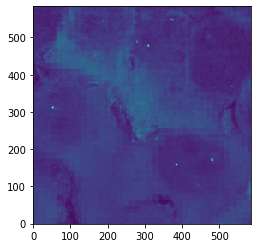

In [34]:
plt.imshow(np.max(filter_zstack_DoG(W4[:,:,:,0]),axis=0),origin='top')

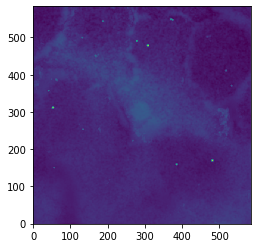

In [35]:
plt.imshow(np.max(filter_zstack_DoG(Z[:,:,:,0]),axis=0),origin='top')

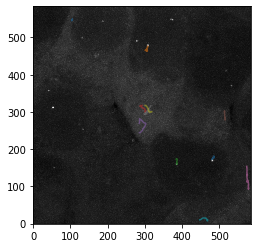

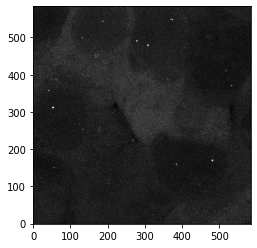

In [22]:
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
for p in linked_df.particle.unique():
    y = linked_df.query(f"particle=={p}").y
    x = linked_df.query(f"particle=={p}").x
    plt.plot(x,y,alpha=0.5)
    
plt.show()
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='top',cmap='gray')

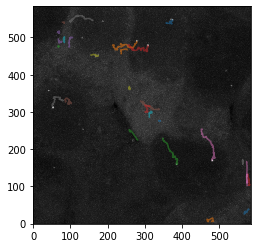

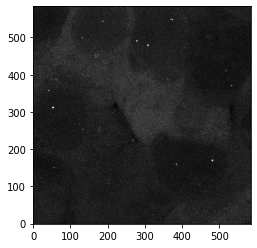

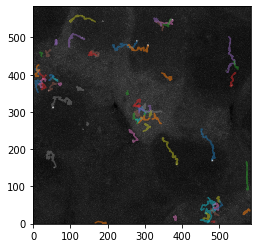

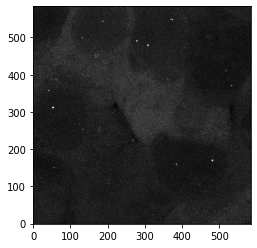

In [16]:
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
for p in linked_df.particle.unique():
    y = linked_df.query(f"particle=={p}").y
    x = linked_df.query(f"particle=={p}").x
    plt.plot(x,y,alpha=0.5)
    
plt.show()
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='top',cmap='gray')

In [15]:
linked_df

,x,y,z,mean_intensity,max_intensity,dot_size_in_pixels,frame,channel,particle
1,479.847648,171.002333,7.096014,0.030780,0.138262,316,0,0,0
44,320.022442,280.558114,14.545107,0.032840,0.045167,120,0,0,2
47,272.993496,295.000477,14.548406,0.031027,0.044694,102,0,0,3
58,13.447410,412.069187,14.524328,0.022381,0.033158,106,0,0,8
61,132.082566,498.060314,17.909076,0.031551,0.089815,174,0,0,10
...,...,...,...,...,...,...,...,...,...
6223,12.650218,352.492996,13.950669,0.022678,0.037430,294,99,0,240
6229,487.147308,37.178834,14.484513,0.026167,0.035706,78,99,0,313
6232,479.461622,57.471147,14.592147,0.025316,0.036713,96,99,0,230
6236,469.398569,69.788802,14.549723,0.026730,0.040482,88,99,0,307


In [ ]:
# create trajectories
min_track_length = 20
tmp_df = loc_df.copy()
tmp_df = trackpy.link_df(tmp_df, \
        search_range=tuple(search_range[ch]), \
        memory=memory[ch])
tmp_df = tmp_df.groupby('particle').filter(lambda x: len(x) > min_track_length)
linked_df = tmp_df.copy()

In [ ]:
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
for p in linked_df.particle.unique():
    y = linked_df.query(f"particle=={p}").y
    x = linked_df.query(f"particle=={p}").x
    plt.plot(x,y,alpha=0.5)
    
plt.show()
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='top',cmap='gray')

In [ ]:
len(linked_df.particle.unique())

In [ ]:
for p in linked_df.particle.unique():
    maxi = linked_df.query(f'particle=={p}').max_intensity
#     meani = linked_df.query(f'particle=={p}').mean_intensity
    plt.plot(maxi)
#     plt.plot(meani)

In [ ]:
# loc_df2, linked_df2 = get_localizations_iterative()
Z.shape

In [ ]:
channels = [0,1]
frames = range(100)
loc_df, linked_df = get_localizations_iterative(W4, Z, frames, channels)

In [ ]:
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
for p in linked_df.particle.unique():
    y = linked_df.query(f"particle=={p}").y
    x = linked_df.query(f"particle=={p}").x
    plt.plot(x,y,alpha=0.5)
    
plt.show()
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='top',cmap='gray')

In [ ]:
# # localization parameters
# max_dot_size = (np.inf,np.inf)#(10000,10000)
# min_dot_size = (0,0)
# max_dot_distance = 3000 
# search_range=[(5,15,15),(5,15,15)] # search range for each channel
# memory = (5,5) # number of allowed "missing frames"
# min_track_length = 15


# min_id_value = 100000000 # some minimum large number for particle IDs in channel 1

# print(f'Tracking in channel {ch}')
# tmp_df = loc_df.copy()
# tmp_df = tmp_df[(tmp_df.dot_size_in_pixels<max_dot_size[ch]) & ((tmp_df.dot_size_in_pixels>min_dot_size[ch]))]
# tmp_df = tmp_df[tmp_df.channel==ch]

# tmp_df = loc_df.copy()
# tmp_df = trackpy.link_df(tmp_df, \
#         search_range=tuple(search_range[ch]), \
#         memory=memory[ch])
# tmp_df = tmp_df.groupby('particle').filter(lambda x: len(x) > min_track_length)

# # make the coordinates of the particles different across channels
# tmp_df.particle = tmp_df.particle.values+ch*min_id_value 
# # tmp_df_list.append(tmp_df)
# # linked_df = pd.concat(tmp_df_list)
# linked_df = tmp_df.copy()

In [ ]:
## Make movie

#make max-proj for a single zstack
def get_zstack_max(input_file,frame,channel, img_info=None,proj_axis=0):
    if img_info is None:
        img_info, metadata = get_CZI_metadata(input_file,filepath=None,verbose=False)

    sizeX,sizeY,sizeZ,sizeT,num_channels = img_info
    
    assert frame < sizeT
    assert channel < num_channels

    zstack = get_CZI_zstack(input_file,frame,channel,img_info=img_info)
    return np.max(zstack,axis=proj_axis)

from matplotlib.patches import Rectangle
from matplotlib import animation

output_file = 'test.mp4'

desired_bar_length_nm = 1000
bar_width = metadata['OME']['Image']['Pixels']['PhysicalSizeX']*desired_bar_length_nm # for length in pixels/um
bar_height = 5

fig = plt.figure(figsize=(10,10))
frame = 0
channel = 0
percent_cutoff = 99.99
img = get_zstack_max(input_file,0,0)
img2 = get_zstack_max(input_file,0,1)
img3 = get_zstack_max(input_file,0,2)
ic = np.percentile(img,percent_cutoff)
ic2 = np.percentile(img2,percent_cutoff)
ic3 = np.percentile(img3,percent_cutoff)
img = img/np.percentile(img,ic)
img2 = img2/np.percentile(img2,ic2)
img3 = img3/np.percentile(img3,ic3)
# img = img/np.percentile(img,percent_cutoff)
# img2 = img2/np.percentile(img2,percent_cutoff)
img[img>1] = 1
img2[img2>1] = 1
img3[img3>1] = 1
img_array = np.zeros((img.shape[1],img.shape[0],3))
img_array[:,:,0] = img2
img_array[:,:,1] = img
img_array[:,:,2] = img3
im = plt.imshow(img_array, animated=True)
#txt = plt.text(20,30,f'Time: {0} s',color='w',)
txt = plt.text(20,30,f'Frame: {0}',color='w',)

line_dict = {}
for ch in [1]:
    particle_set = linked_df.particle[linked_df.channel==ch].unique()
    for p in particle_set:
        line_dict[p] = {}
        line, = plt.plot([0],[0])
        line_dict[p][ch] = line
disp_line_len = 25

rect = Rectangle((sizeX-bar_width-20,sizeY-20), bar_width, bar_height,color='w', angle=0.0)
plt.gca().add_patch(rect)
plt.text(sizeX-bar_width//2-20,sizeY-30,r'1 $\mu$m',color='w',)

fig.gca().get_xaxis().set_visible(False)
fig.gca().get_yaxis().set_visible(False)



def updatefig_2colour(*args):
    img = get_zstack_max(input_file,args[0],0)
    img2 = get_zstack_max(input_file,args[0],1)
    img3 = get_zstack_max(input_file,args[0],2)
#     img = img/np.percentile(img,percent_cutoff)
#     img2 = img2/np.percentile(img2,percent_cutoff)
    img = img/ic#np.percentile(img,ic)
    img2 = img2/ic2#np.percentile(img2,ic2)
    img3 = img3/ic3#np.percentile(img3,ic3)
    img[img>1] = 1
    img2[img2>1] = 1
    img3[img3>1] = 1
    img_array = np.zeros((img.shape[1],img.shape[0],3))
    img_array[:,:,0] = img2
    img_array[:,:,1] = img
    img_array[:,:,2] = img3
    im.set_array(img_array)
    #txt.set_text(f'Time: {args[0]*ft} s')
    txt.set_text(f'Frame: {args[0]}')
    frame = args[0]
    for ch in [1]:
        particle_set = linked_df.particle[linked_df.channel==ch].unique()
        for p in particle_set:
            line = line_dict[p][ch]
            X = linked_df[(linked_df.particle==p) & (linked_df.channel==ch) & linked_df.frame.between(frame-disp_line_len,frame, inclusive=True)].x
            Y = linked_df[(linked_df.particle==p) & (linked_df.channel==ch) & linked_df.frame.between(frame-disp_line_len,frame, inclusive=True)].y
            if len(X) > 0:
                line.set_ydata(Y)
                line.set_xdata(X)
    print(args[0])
    return im,

ani = animation.FuncAnimation(fig, updatefig_2colour,frames=np.arange(0,200,1), interval=500, blit=True)
plt.show()
ani.save('movie1.mp4') 

In [ ]:
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='bottom',cmap='gray')
for p in linked_df.particle.unique():
    y = linked_df.query(f"particle=={p}").y
    x = linked_df.query(f"particle=={p}").x
    plt.plot(x,y,alpha=0.5)
    
plt.show()
plt.imshow(np.max(Z[:,:,:,0],axis=0),origin='top',cmap='gray')

In [ ]:
# get image units and conversion factors
fx = metadata['OME']['Image']['Pixels']['PhysicalSizeX']
fy = metadata['OME']['Image']['Pixels']['PhysicalSizeY']
fz = metadata['OME']['Image']['Pixels']['PhysicalSizeZ']
ft = metadata['OME']['Image']['Pixels']['TimeIncrement']
ux = metadata['OME']['Image']['Pixels']['PhysicalSizeXUnit']
uy = metadata['OME']['Image']['Pixels']['PhysicalSizeYUnit']
uz = metadata['OME']['Image']['Pixels']['PhysicalSizeZUnit']
ut = metadata['OME']['Image']['Pixels']['TimeIncrementUnit']


In [ ]:

verbose=True
min_dot_size = (40,40)#40#40 # min dot size (in number of pixels) - this is a filtering refinement (optional)
max_dot_size = (1000,1000)#5000 # maximum dot size (in number of pixels) - this is a filtering refinement (optional)
max_dot_distance = 3000#2500 # nm

## Run tests

In [ ]:
img_folder = '/mnt/md0/Hansen Lab Dropbox/DataStorage/Imaging/Fbn2/processed/'
name_includes = ['.czi','fbn2','']
name_excludes = ['beads']
filenames_list, filepath_list = search_for(img_folder,name_includes,name_excludes)

# files_list[0]

f = 0
filename = filenames_list[f]
filepath = filepath_list[f]

img_info, metadata = get_CZI_metadata(filename,filepath=filepath)

times = range(100)
ch = 0
f = 0
Z = get_CZI_zstack_timeseries(filenames_list[f],times,ch,filepath=filepath_list[f])

import sys
print(f"Size of Z-stack {sys.getsizeof(Z)/8e9}") # in Gb

In [ ]:
## Raw image, object localization
df, blobs = get_image_objects(Z[:,:,:,0],percentile_threshold=99.94)
plt.imshow(np.max(blobs,axis=0) )
plt.title(len(df))

In [ ]:
## 3D wavelet decomposition, object localization
W3 = wavelet_filter_zstack(Z[:,:,:,99],filtered_levels=[0,4])
W3.shape
plt.imshow(np.max(W3,axis=0))
plt.show()

min_size = 20
df, blobs, blobs_filt = get_image_objects(W3,percentile_threshold=99.99,min_size_pixels=min_size)
plt.imshow(np.max(blobs_filt,axis=0) )
plt.title(len(df));
plt.show()

df, blobs, blobs_filt = get_image_objects(W3,percentile_threshold=99.99,do_dilation=False)
plt.imshow(np.max(blobs_filt,axis=0) )
plt.title(len(df))
plt.show()

plt.imshow(np.max(Z[:,:,:,frame],axis=0) )
plt.show()

In [ ]:
## 4D wavelet decomposition, object localization
W4 = wavelet_filter_zstack(Z,filtered_levels=[0,4])
frame = 99

plt.imshow(np.max(W4[:,:,:,frame],axis=0))
plt.show()

df, blobs,blobs_filt = get_image_objects(W4[:,:,:,frame],percentile_threshold=99.99)
plt.imshow(np.max(blobs_filt,axis=0) )
plt.title(len(df));
plt.show()

df, blobs,blobs_filt = get_image_objects(W4[:,:,:,frame],percentile_threshold=99.99,do_dilation=False)
plt.imshow(np.max(blobs_filt,axis=0) )
plt.title(len(df));
plt.show()

plt.imshow(np.max(Z[:,:,:,frame],axis=0) )
plt.show()